# **Capstone Project**

### **Pneumonia Detection**

**Problem Statement:** Chest Radiograph is the most commonly used or performed diagnostic imaging Technology. Due to high volume of chest radiography, it could be very time consuming and intensive for the radiologists to review each image manually. As such, an automated solution is ideal to locate the position of inflammation in an image. By having such an automated pneumonia screening system, this can assist physicians to make better clinical decisions.

**Business Domain Value:** Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

In [47]:
# Mounting Google CoLab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [48]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Wed Oct 13 18:12:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------

In [49]:
# Import all required libraries
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import os
from matplotlib.patches import Rectangle
np.random.seed(22)

In [ ]:
# Install pydicom package to handle .dcm files

!pip install pydicom
import pydicom

**Pre-Processing, Data Visualization, EDA**

In [52]:
# Setting path
root_path =  '/content/drive/MyDrive/AI_ML_Projects/Capstone Project/'
os.chdir(root_path)

In [53]:
# Checking file format (.dcm) in the train images folder

for file in os.listdir((os.path.join(root_path,'stage_2_train_images'))):
  if not file.endswith('.dcm'):
    print(file)
  #else:
    #print('All files inside Train Images folder are .dcm format')

In [54]:
# Checking file format (.dcm) in the test images folder

for file in os.listdir((os.path.join(root_path,'stage_2_test_images'))):
  if not file.endswith('.dcm'):
    print(file)
  #else:
    #print('All files inside Test Images folder are .dcm format')

In [55]:
# Check for number of training images available

len(os.listdir((os.path.join(root_path,'stage_2_train_images'))))

26684

In [56]:
# Check for number of test images available

len(os.listdir((os.path.join(root_path,'stage_2_test_images'))))

3000

In [57]:
# Load stage_2_detailed_class_info.csv file

df_class = pd.read_csv('stage_2_detailed_class_info.csv')
df_class.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [58]:
# Checking info of stage_2_detailed_class_info pandas table

df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [59]:
# Check for missing values in the class label file

df_class.isnull().sum()

patientId    0
class        0
dtype: int64

In [60]:
# Check for duplicate patientID in class label file

df_class.duplicated().sum()

3543

In [61]:
# Check for types of class labels 

df_class["class"].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [62]:
# Check for % of each category in the dataset

df_class["class"].value_counts() / len(df_class)

No Lung Opacity / Not Normal    0.391074
Lung Opacity                    0.316108
Normal                          0.292818
Name: class, dtype: float64

In [63]:
# Load stage_2_train_labels.csv file

df_label = pd.read_csv('stage_2_train_labels.csv')
df_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [64]:
# Checking info of stage_2_train_labels

df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [65]:
# Check for missing values in the train label file

df_label.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [66]:
# Check for duplicate patientID in train label file

df_label.duplicated().sum()

0

Target
0    0.683892
1    0.316108
dtype: float64


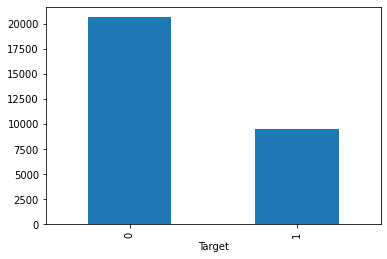

In [67]:
# Plotting depends upon Target Values

df_label.groupby('Target').size().plot.bar()
print(df_label.groupby('Target').size() / df_label.shape[0])

class
Lung Opacity                    0.316108
No Lung Opacity / Not Normal    0.391074
Normal                          0.292818
dtype: float64


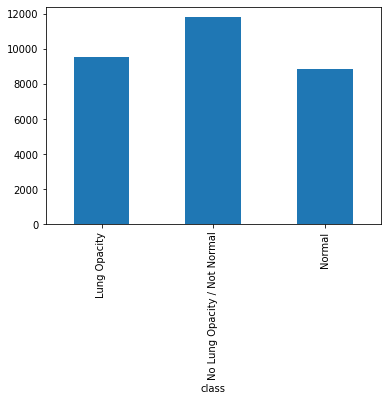

In [68]:
# Plotting data depends upon Class

df_class.groupby('class').size().plot.bar()
print(df_class.groupby('class').size() / df_class.shape[0])
assert df_label.loc[df_label['Target']==0].shape[0] == df_class.loc[df_class['class'].isin(['Normal', \
    'No Lung Opacity / Not Normal'])].shape[0], 'Number of negative targets does not match between main and auxiliary dataset.'
assert df_label.loc[df_label['Target']==1].shape[0] == df_class.loc[df_class['class'] == 'Lung Opacity'].shape[0], \
    'Number of positive targets does not match between main and auxiliary dataset.'

In [69]:
# Check for mismatches betwen the 2 csv files

list_class_Id = list(df_class['patientId'])
list_label_Id = list(df_label['patientId'])

if list_class_Id == list_label_Id: 
    print ("The patientIds in both files are identical") 
else : 
    print ("The patientIds in both files  are not identical")

The patientIds in both files are identical


In [70]:
# Check for mismatches between the csv files and the DICOM training image files

list_DICOM_Id = []
for i in os.listdir((os.path.join(root_path,'stage_2_train_images'))):
  list_DICOM_Id.append(i.split('.')[0])

if set(list_class_Id) == set(list_DICOM_Id): 
    print ("The patientIds in both files are identical. There are duplicate patientIds in the csv files.") 
else : 
    print ("The patientIds in both files  are not identical. There is a mismatch in patientIds between the DICOM files and the csv files.")

The patientIds in both files are identical. There are duplicate patientIds in the csv files.


In [71]:
# Confirm difference in count

len(list_class_Id) - len(list_DICOM_Id)

3543

In [72]:
assert df_class['patientId'].values.tolist() == df_label['patientId'].values.tolist(), 'PatientId columns are different.'
df_train = pd.concat([df_class, df_label.drop(labels=['patientId'], axis=1)], axis=1)
df_train.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [73]:
# Checking concatinated data frame size

df_train.groupby(['class', 'Target']).size()

class                         Target
Lung Opacity                  1          9555
No Lung Opacity / Not Normal  0         11821
Normal                        0          8851
dtype: int64

In [74]:
# Checking Null Values

df_train.isnull().any()

patientId    False
class        False
x             True
y             True
width         True
height        True
Target       False
dtype: bool

In [75]:
# When target==1, are any of the box coordinates null? As per logic, should be false.

df_train.loc[df_train['Target']==1, ['x', 'y', 'width', 'height']].isnull().any()

x         False
y         False
width     False
height    False
dtype: bool

In [76]:
# when target==0, are all of the box coordinates null? As per logic, should be true.

df_train.loc[df_train['Target']==0, ['x', 'y', 'width', 'height']].isnull().all()

x         True
y         True
width     True
height    True
dtype: bool

In [77]:
# check that there is an image for each unique patient ID
assert sorted(df_train['patientId'].unique().tolist()) == sorted([f[:-4] for f in os.listdir(root_path+'stage_2_train_images/')]), \
    'Discrepancy between patient IDs and radiograph images.'

### **Observations:** 
Images from the **"stage_2_train_images"** folder are taken via CXR, which is a chest x-ray. It produces images of the heart, lungs, airways, blood vessels and the bones of the spine and chest. Each image corresponds to the x-ray of a unique patientId. It is accompanied by 2 sets of files, "stage_2_detailed_class_info" and "stage_2_train_labels".
There are 26,684 DICOM image files. From the above, there appears to have more records in "stage_2_detailed_class_info" and "stage_2_train_labels" files with a number of 30,227 records, a difference of 3,543. This might be due to additional records to detect different pneumonia areas within the same x ray image. We can confirm this later when we take a deeper look at the DICOM images.



**"stage_2_detailed_class_info"**

"stage_2_detailed_class_info" file contains the class labelling of the patientIds' xray image into 3 classes, "No Lung Opacity / Not Normal", "Normal" and "Lung Opacity". There is no missing data from this file. There is a slight imbalance in the proportion of available data for "No Lung Opacity / Not Normal" at 39%, and 31% and 29% for "Normal" and "Lung Opacity" respectively.


**"stage_2_train_labels"**

"stage_2_train_labels" contains the bounding boxes of detected pneumonia in the corresponding patientIds' xray images with the x and y co-ordinates and the height and weight of the box, and a target column which is either a 1 for pneumonia detected, and hence will have a bounding box, or 0 for no pneumonia detected. When pneumonia is detected, it will correspond to the label of "Lung Opacity" in the "stage_2_detailed_class_info" file. There are 9,555 records of patientIDs with bounding boxes, and this corresponds to the number of labels of "Lung Opacity" in the "stage_2_detailed_class_info" file.



**Exploratory Data Analysis**

Label: No Lung Opacity / Not Normal
0004cfab-14fd-4e49-80ba-63a80b6bddd6


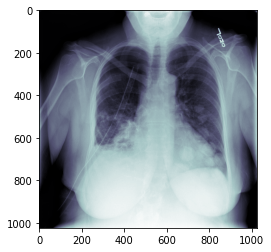

In [80]:
# DICOM image with class label "No Lung Opacity / Not Normal"

print('Label: No Lung Opacity / Not Normal')
print(df_class['patientId'][0])

filename = df_class['patientId'][0] + '.dcm'
filename = (os.path.join(root_path,'stage_2_train_images',filename))

dataset = pydicom.dcmread(filename)

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

Label: Normal
003d8fa0-6bf1-40ed-b54c-ac657f8495c5


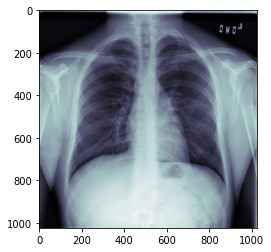

In [79]:
# DICOM image with class label "Normal"

print('Label: Normal')
print(df_class['patientId'][3])

filename = df_class['patientId'][3] + '.dcm'
filename = (os.path.join(root_path,'stage_2_train_images',filename))

dataset = pydicom.dcmread(filename)

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

Label: Lung Opacity
00436515-870c-4b36-a041-de91049b9ab4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


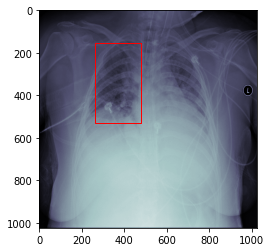

In [81]:
# DICOM image with class label "Lung Opacity"

from matplotlib.patches import Rectangle

print('Label: Lung Opacity')
print(df_class['patientId'][4])

filename = df_class['patientId'][4] + '.dcm'
filename = (os.path.join(root_path,'stage_2_train_images',filename))

dataset = pydicom.dcmread(filename)

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)

bb = Rectangle((df_label['x'][4], df_label['y'][4]), df_label['width'][4], df_label['height'][4], fill=False, color='red')

plt.axes().add_patch(bb)
plt.show()

Label: Lung Opacity
00436515-870c-4b36-a041-de91049b9ab4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


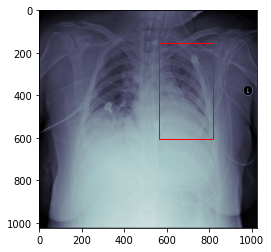

In [82]:
# DICOM image with class label "Lung Opacity"

from matplotlib.patches import Rectangle

print('Label: Lung Opacity')
print(df_class['patientId'][5])

filename = df_class['patientId'][5] + '.dcm'
filename = (os.path.join(root_path,'stage_2_train_images',filename))

dataset = pydicom.dcmread(filename)

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)

bb = Rectangle((df_label['x'][5], df_label['y'][5]), df_label['width'][5], df_label['height'][5], fill=False, color='red')

plt.axes().add_patch(bb)
plt.show()

Label: Lung Opacity
0100515c-5204-4f31-98e0-f35e4b00004a


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


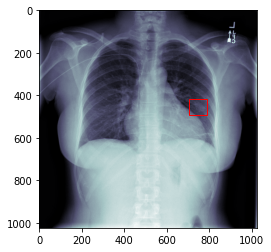

In [84]:
# DICOM image with class label "Lung Opacity"

from matplotlib.patches import Rectangle

print('Label: Lung Opacity')
print(df_class['patientId'][22])

filename = df_class['patientId'][22] + '.dcm'
filename = (os.path.join(root_path,'stage_2_train_images',filename))

dataset = pydicom.dcmread(filename)

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)

bb = Rectangle((df_label['x'][22], df_label['y'][22]), df_label['width'][22], df_label['height'][22], fill=False, color='red')

plt.axes().add_patch(bb)
plt.show()

**EDA Observations:** 

Details of EDA of some images, I have loaded a few DICOM image files for visualization. I have loaded couple of images from each of the 3 classes, "No Lung Opacity / Not Normal", "Normal" and "Lung Opacity". For images labelled with "Lung Opacity", I have marked with bounding box which detected the lung opacity / inflammation area for pneumonia in red.

The first image I have loaded is labelled with "No Lung Opacity / Not Normal". From this image, it is loaded as monochromatic, where white usually reveals the bones, skin and organs of the person. Normal lungs will not absorb X-Rays and shows in dark color. We can see the spinal cord and the rib clearly. Where there are black patches, they are empty space. For this set of lungs, there are some faint white patches in the lung area, when it is expected to be empty, ie black. This might be the case why the image is labelled with "No Lung Opacity / Not Normal".

For the second loaded image, it is labelled with "Normal". Here I can see that the area of lungs is clearer compared to the first image. Although visually, it appears to be only slightly clearer compared to the first image.

For the third and fourth loaded images, they are labelled with "Lung Opacity". They are actually duplicate patientIDs and I loaded both of them to see if there are any differences. The third image has the bounding box locating the opacity on the right side lung, while the fourth image has the bounding box locating the opacity on the left side lung, both pointing to the same patientID. This makes sense as pneumonia may develop on either side of the lungs or both lungs as well. This might be why as to there being duplicate patientIDs in the csv files as they may point to 2 separate records of both lung sides detecting the opacity. It would make sense to retain the 2 records, so that the algorithmn created will be able to detect lung opacity in both sides of the lungs, rather than being skewed or bias to only be able to detect 1 side of the lungs. As such, I will not be removing the duplicate patientId records from the file.

For the 5th and final image loaded, it is labelled with "Lung Opacity". I loaded this to check as the bounding box region provided is quite small, and I would like to see if there are any issues with this. To be honest, as I am not an expert in this domain, visually inspecting it does not really tell me much that this indeed has lung opacity. However, it does make sense that pneumonia may not necessarily be apparent, and this might be a case of early detection, since the bounding box area is relatively small compared to the previous 2 images.

The above analysis of the images highlight the difficulty in visual inspection of the DICOM images and further strengthens the need for an algorithmn to be able to assist the medical practioners in making better informed decisions. Despite the duplicate records and uncertain lung opacity detection, I would still retain all the data for training my model.